# IMDB Text Sentiment Classification

- Word Seq -> Embedding -> Concat (a long concatenation) -> Linear FNN -> SoftMax

**TODO Later sometime**
- CNN
- LSTM/GRU

In [2]:
import torch
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.datasets

In [3]:
%matplotlib inline

## Get IMDB sentiment classification data set
1. https://ai.stanford.edu/~amaas/data/sentiment/
1. Download, decompress

- The data was collected by Stanford researchers 
- and was used in a 2011 paper where a splitof 50-50 of the data was used for training and test. 
- An accuracy of 88.89% was achieved.

In [4]:
import os
os.listdir('.data/imdb/aclImdb/')

['imdb.vocab', 'imdbEr.txt', 'my_imdb.pkl', 'README', 'test', 'train']

In [5]:
import imdb_data_load
xtr, ytr, xte, yte = imdb_data_load.load_imdb('.data/imdb/aclImdb', loadpkl=False)

load_imdb():  .data/imdb/aclImdb\my_imdb.pkl
load_from: .data/imdb/aclImdb\train/pos
load_from: .data/imdb/aclImdb\train/neg
12500 12500
load_from: .data/imdb/aclImdb\test/pos
load_from: .data/imdb/aclImdb\test/neg
12500 12500


### Let's have a look at the data

In [6]:
i = 0
print(f'label: {ytr[i]}\ndata[{i}]: (len: {len(xtr[i])}) {xtr[i][:10]}')
print('---')
print('xtr[0]>> ', xtr[0])
print('---')
print('xtr[500]>>', xtr[500])

label: 1
data[0]: (len: 140) ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the']
---
xtr[0]>>  ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........

## Vocabulary Making
- Use train data only to build up a vocabulary

In [7]:
vocab_src = set() # empty set
for string in xtr:
    vocab_src.update(string)
#
len(vocab_src)

280617

### Mapping from index to word, word to index

In [8]:
def get_maps(vocab):
    print('get_maps: ', len(vocab))
    word2indx, indx2word = {}, {}
    for v, w in enumerate(vocab):
        word2indx[w] = v
        indx2word[v] = w    # this can just be a list instead of {}
    return word2indx, indx2word
#

def get_words(i2w, inds):
    return [i2w[i] for i in inds]

word2indx_src, indx2word_src = get_maps(vocab_src)

get_maps:  280617


### Histogram of words in the whole dataset
- Some words in test data are not known 

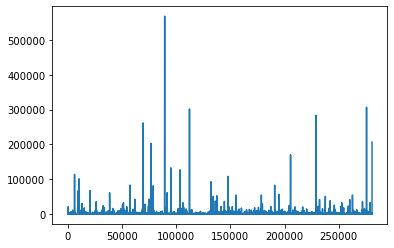

In [11]:
hist = np.zeros(len(vocab_src)+1, dtype=np.int)

for list_of_strings in [xtr, xte]:
    for wlst in list_of_strings:
        for w in wlst:
            if w in vocab_src:
                i = word2indx_src[w]
                hist[i] += 1
            else:
                hist[-1] +=1
plt.plot(hist)

In [12]:
print(f'* Maximum frequently used word: ', indx2word_src[np.argmax(hist)])
print(f'* Frequent Words:')
for i in range(len(vocab_src)):
    if hist[i] > 50000:
        print(indx2word_src[i], hist[i], end='; ')

* Maximum frequently used word:  the
* Frequent Words:
this 113726; but 66282; /><br 100974; The 67317; movie 60762; as 83130; to 261850; is 203056; for 80919; the 568735; on 61197; I 132498; that 126818; and 301919; was 92658; you 50697; not 52140; it 107916; have 54009; his 54198; with 82569; are 56513; in 169981; of 283625; be 50539; film 54277; a 306960; 

## Choose words and make a new vocab

In [13]:
mask = (7 <= hist ) & (hist < 50000)
print(f'Chosen words: {mask.sum()}  among  {mask.shape}')
windx = [i for i in range(len(mask)) if mask[i]]

# new vocab and maps
vocab = [indx2word_src[i] for i in windx] + ['<SOS>', '<EOS>', '<UNK>', '<PAD>']
word2indx, indx2word = get_maps(vocab)

print('size of new vocab: ', len(vocab))
#
unk_indx = word2indx['<UNK>']
pad_indx = word2indx['<PAD>']

Chosen words: 58437  among  (280618,)
get_maps:  58441
size of new vocab:  58441


In [14]:
len(vocab), len(set(vocab))

(58441, 58441)

## Convert a sentence (word-list) to list of integer index
- Embedding will be used for NN model

### Examine the lengths of all the sentences

mean: 233.7872, min: 10  max: 2470  std: 173.7, median: 174.0


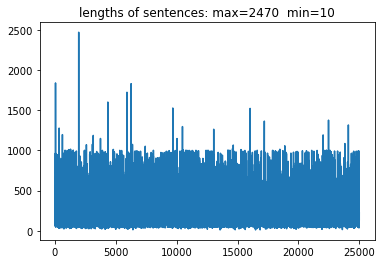

In [15]:
length = np.array([len(wlst) for wlst in xtr])
print(f'mean: {length.mean()}, min: {length.min()}  max: {length.max()}  std: {length.std():.1f}, median: {np.median(length)}')

plt.plot(length)
plt.title(f'lengths of sentences: max={max(length)}  min={min(length)}');

## Make Tensor array

In [16]:
max_len = 100  # we will use only 100 words per a sentence

In [19]:
def wseq2numpy(seq, vocab, word2indx, indx2word, max_len=200):
    """ seq: input, list of list of words, xtr or xte: [ ['From', 'the', 'world'], ['hello', 'world', 'c', 'c++'], ...]
        out: numpy array of ints [ [ 100, 23, 32], [32, 22, 10], ...]
    """
    print(len(seq), max_len)
    
    out = np.zeros((len(seq), max_len), dtype=np.int64)
    
    for i in range(len(seq)):
        s = seq[i]
        a = out[i]
        if len(s) >= max_len:   # if longer, trim
            s = s[:max_len]
        else:
            s = s + ['<PAD>' for i in range(max_len-len(s))]  # if shorter, pad
            
        for j, w in enumerate(s): # change to index 
            if w in vocab:
                a[j] = word2indx[w]
            else:
                a[j] = word2indx['<UNK>']
                
        if i == 0:
            print(f'{i} {seq[i]}')
    #
    return out

In [20]:
# set searching is much much faster than list searching
xtrain = wseq2numpy(xtr, set(vocab), word2indx, indx2word, max_len=max_len)
xtest  = wseq2numpy(xte, set(vocab), word2indx, indx2word, max_len=max_len)

25000 100
0 ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'High.', 'A', 'classic', 'line:', 'INSPECTOR:', "I'm", 'here', 'to', 'sack', 'one', 'of'

In [21]:
xtrain.shape, xtrain[0]

((25000, 100),
 array([46485, 57136, 58439, 58439, 52806, 21672, 52297, 21404, 15514,
        58439,  8695, 21253, 58439, 14790, 19096, 30955, 30759,  2600,
        15158, 36569, 58439, 58439, 46687, 20133, 50381, 58439, 58439,
        39865,  2915, 34712, 12858, 58439,  7019, 58439, 46485, 58439,
         3388, 58439, 33305, 52730, 58439,  8030, 36545, 58439, 58439,
        58439, 22387, 58439, 14334, 58439, 58439, 19094, 18945, 28298,
        11281, 30916, 51189, 27343, 47908, 54378, 58439, 58439, 58439,
        58439, 58439, 58439, 18768, 37981,  5481, 28745, 12858, 58439,
        58439, 57452, 58439, 57521, 58439, 47908, 43682,  9396, 58439,
        58000, 58439, 12488, 58439,   120, 58439, 57617,  8231,  5568,
        58439, 41790, 26937, 58439, 41501, 58439, 37328, 51340,  2637,
        15514], dtype=int64))

In [22]:
print(xtr[0])
print('---')
print(get_words(indx2word, xtrain[0]))

['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'High.', 'A', 'classic', 'line:', 'INSPECTOR:', "I'm", 'here', 'to', 'sack', 'one', 'of', 'your', 't

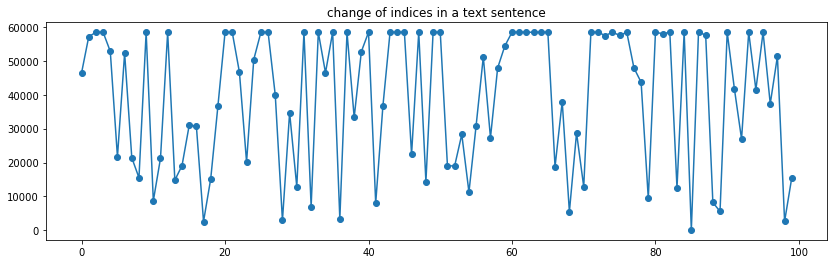

In [24]:
plt.figure(figsize=(14,4))
plt.plot(xtrain[0], '-o')
plt.title('change of indices in a text sentence');

In [25]:
word2indx['<UNK>']

58439

In [26]:
unique, counts = np.unique(xtrain[0], return_counts=True)
print(unique, counts)
print(indx2word[unique[np.argmax(counts)]])

[  120  2600  2637  2915  3388  5481  5568  7019  8030  8231  8695  9396
 11281 12488 12858 14334 14790 15158 15514 18768 18945 19094 19096 20133
 21253 21404 21672 22387 26937 27343 28298 28745 30759 30916 30955 33305
 34712 36545 36569 37328 37981 39865 41501 41790 43682 46485 46687 47908
 50381 51189 51340 52297 52730 52806 54378 57136 57452 57521 57617 58000
 58439] [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  2  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  2
  1  1  1  1  1  1  1  1  1  1  1  1 36]
<UNK>


---
## Dataset and Dataloader for PyTorch NN Modeling

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [28]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x  # np.array(N, max_len)
        self.y = y  # label
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [29]:
ds = Dataset(xtrain, ytr)
ds[21110]

(array([42358, 58439, 58439, 22663, 58439,  2015, 58439, 10374, 25867,
        14250, 58439, 44903,  7814, 58439, 58439, 58439, 32575, 58439,
         2781, 15803, 58439, 58439, 24677, 30759, 58439, 58439, 58439,
        58439,  9601, 37316,  4259,  7441, 58439, 58439, 53407,  2617,
        22493, 50433,  6216,  2005, 25744, 58439,  2781, 29859, 58439,
        58439, 58439, 58439, 40741, 58439, 12893, 47908,  9601,  6216,
        10733, 23615, 39067, 58439, 38948,  6791, 58439, 50263, 30995,
        58439, 31963, 58439, 19230, 24677, 27748, 58439,  6791, 58439,
        50562,  7947,  6935,  7441, 58439, 58439, 53407,  2617, 13669,
         6216, 58439,  9727, 18814, 58439, 58439,  9268, 57542, 58439,
         9538, 52915, 43875,  2781, 58439, 58439, 13965, 11466,  3800,
        58439], dtype=int64), 0)

In [30]:
batch_size = 4
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

In [31]:
print(len(data_loader['train'].dataset), len(data_loader['val'].dataset))

for x, y in data_loader['train']:
    print(x.dtype, y.dtype)
    print(x.shape, y)
    break

25000 25000
torch.int64 torch.int64
torch.Size([4, 100]) tensor([0, 0, 1, 1])


## Network Design
Very simple FF linear model:
1. nn.Embedding: word_index -> Euclidean Vector Mapping
1. nn.Linear()
1. Softmax + CrossEntropy = CrossEntropyLoss

### Practice layer by layer

#### nn.Embedding()

* Remember the output shape from embedding.
    - Batch x Sequence(Time) x Feature

In [32]:
vocab_len = len(vocab)
embed_dim = 9

emb = nn.Embedding(num_embeddings=vocab_len, 
                   embedding_dim=embed_dim,
                   padding_idx=word2indx['<PAD>'])

print( emb.weight.shape,'\n', emb.weight)
print('---')
for x, y in data_loader['train']:
    r = emb(x)
    print(f'input({x.shape}) --> embedded({r.shape})')
    break

torch.Size([58441, 9]) 
 Parameter containing:
tensor([[ 0.5440, -1.0334,  1.3553,  ..., -0.6731, -0.7184,  1.4221],
        [ 0.3320, -0.3804,  1.2252,  ...,  1.1194, -0.1440, -0.7214],
        [-1.3971, -0.0071,  0.0498,  ...,  0.7474, -0.2275,  0.8472],
        ...,
        [ 0.1957, -0.3085, -0.0024,  ...,  0.4224, -0.8716,  1.3849],
        [-1.6232,  1.3290,  1.5285,  ...,  0.6688,  1.6477,  0.7074],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)
---
input(torch.Size([4, 100])) --> embedded(torch.Size([4, 100, 9]))


#### nn.Flatten()

In [33]:
flatten = nn.Flatten()

f = flatten(r)
print(f'flattened shape: {f.shape} == {r.shape[1]}x{r.shape[2]}')

flattened shape: torch.Size([4, 900]) == 100x9


#### nn.Linear()

In [34]:
in_dim =f.shape[-1]
out_dim = 2 # sentiment: [pos, neg]
linear = nn.Linear(in_features=in_dim, out_features=2)

score = linear(f)
print(score.shape)

torch.Size([4, 2])


### Make NN Model

In [35]:
def make_model(vocab_size = len(vocab), edim = 40, seq_len = max_len, n_target = 2):

    net = nn.Sequential(
        nn.Embedding(num_embeddings=vocab_size, embedding_dim=edim, padding_idx=word2indx['<PAD>']),
        nn.Flatten(), # seq_len * 20 dimensional vector
        nn.Linear(in_features=seq_len*edim, out_features=edim*seq_len//2),
        nn.Tanh(),
        nn.Linear(in_features=edim*seq_len//2, out_features=n_target)
    )
    
    return net
#

In [36]:
net = make_model()
print(net)

Sequential(
  (0): Embedding(58441, 40, padding_idx=58440)
  (1): Flatten()
  (2): Linear(in_features=4000, out_features=2000, bias=True)
  (3): Tanh()
  (4): Linear(in_features=2000, out_features=2, bias=True)
)


In [37]:
# sanity check
net(x)

tensor([[-0.0426, -0.1520],
        [ 0.3611, -0.1134],
        [-0.3882, -0.5910],
        [-0.0844, -0.2081]], grad_fn=<AddmmBackward>)

## Training Loop

In [38]:
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None, lr_scheduler=None):
    if hist is not None:
        pass
    else:
        hist = {'tloss': [], 'tacc': [], 'vloss': [], 'vacc': []}
    #
    if lr_scheduler is not None:
        lr = []
        
    best_acc = 0
    for epoch in range(1, n_epochs+1):
        tr_loss, tr_acc = 0., 0.
        n_data = 0
        for im_batch, label_batch in dl_train: # minibatch
            im_batch, label_batch = im_batch.to(device), label_batch.to(device)
            ypred = model(im_batch)
            loss_train = loss_fn(ypred, label_batch)
        
            optim.zero_grad()
            loss_train.backward()
            optim.step()
            
            # accumulate correct prediction
            tr_acc  += (torch.argmax(ypred.detach(), dim=1) == label_batch).sum().item() # number of correct predictions
            tr_loss += loss_train.item() * im_batch.shape[0]
            n_data  += im_batch.shape[0]
        # end mini-batch loop
        
        # statistics
        tr_loss /= n_data
        tr_acc  /= n_data
        #
        val_loss, val_acc = performance(model, loss_fn, dl_val)
        
        if epoch <= 5 or epoch % 1000 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, tloss {tr_loss:.2f} t_acc: {tr_acc:.2f}  vloss {val_loss:.2f}  v_acc: {val_acc:.2f}')
        
        # best accuracy
        if best_acc < val_acc:
            best_acc = val_acc
            print(f' >> best val accuracy updated: {best_acc} at epoch {epoch}.')
        #
        # record for history return
        if hist is not None:
            hist['tloss'].append(tr_loss)
            hist['vloss'].append(val_loss) 
            hist['tacc'].append(tr_acc)
            hist['vacc'].append(val_acc)
            
        if lr_scheduler is not None:
            lr.append(lr_scheduler.get_lr()) # the lr used in optim.
            lr_scheduler.step()
        # end epoch-loop
        
    if lr_scheduler is not None:
        hist['lr'] = lr
        
    print ('finished training_loop().')
    return hist
#

def performance(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred, y).item() * len(y)
            p = torch.argmax(ypred, dim=1)
            acc += (p == y).sum().item()
            n += len(y)
        #
    loss /= n
    acc /= n
    model.train()
    return loss, acc
#
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    max_vacc = max(history['vacc'])
    axes[1].set_title(f'Acc. vbest: {max_vacc:.2f}')
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()
#

## Training Setup

In [39]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

history = None

cuda


## First Trial

Epoch 1, tloss 53.91 t_acc: 0.50  vloss 60.44  v_acc: 0.50
 >> best val accuracy updated: 0.5 at epoch 1.
Epoch 2, tloss 33.54 t_acc: 0.50  vloss 46.96  v_acc: 0.50
Epoch 3, tloss 28.51 t_acc: 0.50  vloss 17.40  v_acc: 0.50
Epoch 4, tloss 27.15 t_acc: 0.50  vloss 29.26  v_acc: 0.50
 >> best val accuracy updated: 0.50016 at epoch 4.
Epoch 5, tloss 19.06 t_acc: 0.51  vloss 9.09  v_acc: 0.53
 >> best val accuracy updated: 0.52508 at epoch 5.
 >> best val accuracy updated: 0.60828 at epoch 6.
 >> best val accuracy updated: 0.6264 at epoch 7.
 >> best val accuracy updated: 0.66496 at epoch 9.
Epoch 10, tloss 0.45 t_acc: 0.85  vloss 1.55  v_acc: 0.65
finished training_loop().
Wall time: 7.46 s


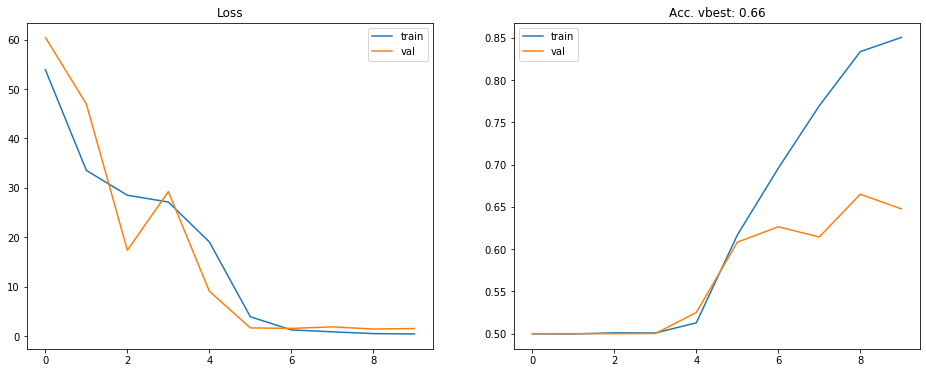

In [40]:
%%time
history = training_loop(10, optimizer, model, criterion,
                        data_loader['train'], data_loader['val'], 
                        history, 
                        lr_scheduler=lr_scheduler)
plot_history(history)

Epoch 1, tloss 0.47 t_acc: 0.84  vloss 2.09  v_acc: 0.61
 >> best val accuracy updated: 0.61388 at epoch 1.
Epoch 2, tloss 0.33 t_acc: 0.89  vloss 1.29  v_acc: 0.69
 >> best val accuracy updated: 0.69472 at epoch 2.
Epoch 3, tloss 0.19 t_acc: 0.93  vloss 1.28  v_acc: 0.69
Epoch 4, tloss 0.15 t_acc: 0.94  vloss 1.46  v_acc: 0.67
Epoch 5, tloss 0.16 t_acc: 0.94  vloss 1.28  v_acc: 0.69
 >> best val accuracy updated: 0.69756 at epoch 6.
 >> best val accuracy updated: 0.69876 at epoch 7.
 >> best val accuracy updated: 0.701 at epoch 8.
 >> best val accuracy updated: 0.70256 at epoch 15.
 >> best val accuracy updated: 0.70324 at epoch 17.
 >> best val accuracy updated: 0.70328 at epoch 20.
Epoch 100, tloss 0.01 t_acc: 1.00  vloss 1.43  v_acc: 0.70
finished training_loop().
Wall time: 1min 8s


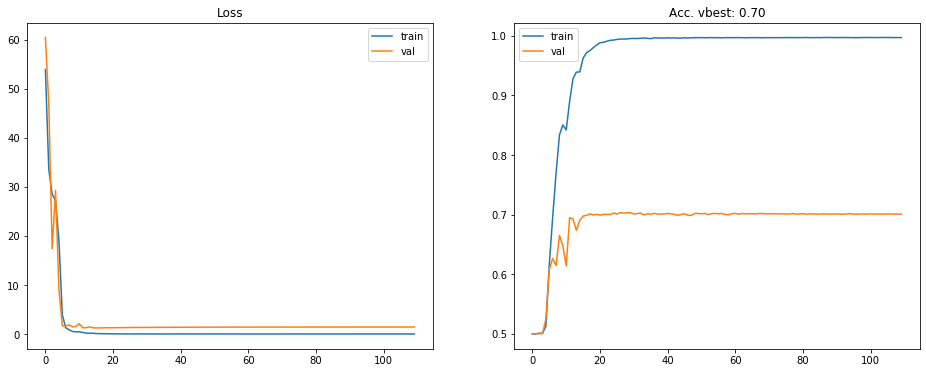

In [41]:
%%time
history = training_loop(100, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        history,
                        lr_scheduler=lr_scheduler)
plot_history(history)

## Try `lr_scheduler.CosineAnnealingWarmRestarts()`

In [42]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

cuda


## First Trial

Epoch 1, tloss 29.35 t_acc: 0.50  vloss 0.94  v_acc: 0.51
 >> best val accuracy updated: 0.51108 at epoch 1.
Epoch 2, tloss 9.49 t_acc: 0.52  vloss 9.72  v_acc: 0.52
 >> best val accuracy updated: 0.52064 at epoch 2.
Epoch 3, tloss 3.07 t_acc: 0.69  vloss 3.76  v_acc: 0.52
Epoch 4, tloss 1.59 t_acc: 0.79  vloss 2.69  v_acc: 0.68
 >> best val accuracy updated: 0.67872 at epoch 4.
Epoch 5, tloss 0.60 t_acc: 0.88  vloss 1.20  v_acc: 0.74
 >> best val accuracy updated: 0.74192 at epoch 5.
 >> best val accuracy updated: 0.74392 at epoch 6.
 >> best val accuracy updated: 0.74496 at epoch 9.
Epoch 10, tloss 0.08 t_acc: 0.97  vloss 0.92  v_acc: 0.74
finished training_loop().
Wall time: 6.94 s


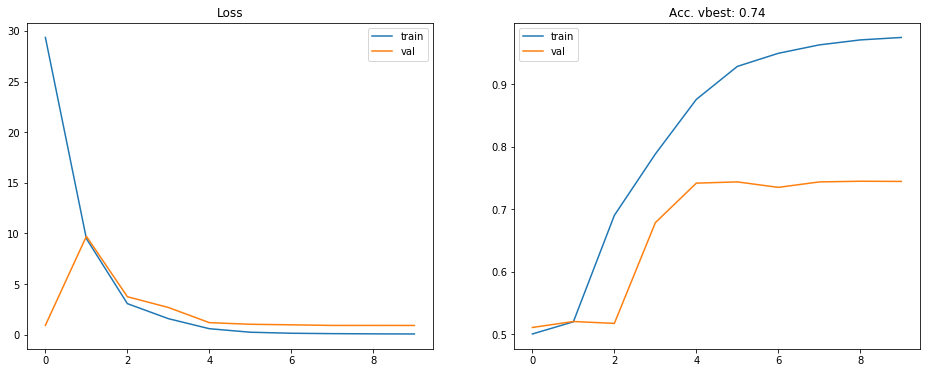

In [43]:
%%time
history = training_loop(10, optimizer, model, criterion,
                        data_loader['train'], data_loader['val'], 
                        history, 
                        lr_scheduler=lr_scheduler)
plot_history(history)

Epoch 1, tloss 1.00 t_acc: 0.90  vloss 2.72  v_acc: 0.74
 >> best val accuracy updated: 0.73916 at epoch 1.
Epoch 2, tloss 0.17 t_acc: 0.96  vloss 1.70  v_acc: 0.74
Epoch 3, tloss 0.09 t_acc: 0.97  vloss 1.75  v_acc: 0.72
Epoch 4, tloss 0.07 t_acc: 0.98  vloss 1.55  v_acc: 0.74
Epoch 5, tloss 0.04 t_acc: 0.99  vloss 1.60  v_acc: 0.74
 >> best val accuracy updated: 0.73924 at epoch 5.
 >> best val accuracy updated: 0.74116 at epoch 8.
 >> best val accuracy updated: 0.74136 at epoch 10.
 >> best val accuracy updated: 0.7418 at epoch 14.
 >> best val accuracy updated: 0.74248 at epoch 16.
 >> best val accuracy updated: 0.74252 at epoch 18.
 >> best val accuracy updated: 0.74256 at epoch 20.
 >> best val accuracy updated: 0.74284 at epoch 24.
 >> best val accuracy updated: 0.74296 at epoch 26.
Epoch 100, tloss 0.00 t_acc: 1.00  vloss 2.10  v_acc: 0.74
finished training_loop().
Wall time: 1min 8s


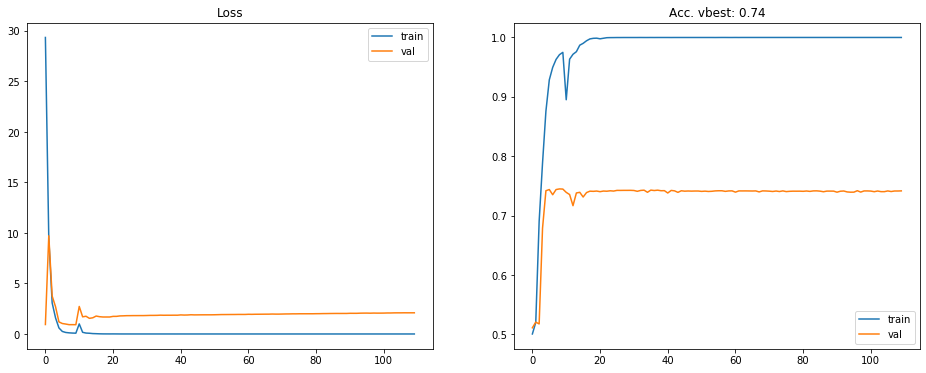

In [44]:
%%time
history = training_loop(100, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        history,
                        lr_scheduler=lr_scheduler)
plot_history(history)

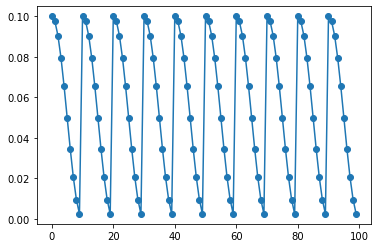

In [45]:
plt.plot(history['lr'], '-o')

## Hypter parameters
- the number of words (size of vocab)
- maximum length of the sequence
- embedding dimension
- size of linear network
- learning rate, schedule

## References
- [https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data](https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data)
- https://github.com/lesley2958/twilio-sent-analysis

End.